In [15]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
from numpy import mean
from numpy import std
from numpy import absolute
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from matplotlib.colors import ListedColormap
from imblearn.over_sampling import SMOTENC
from sklearn.metrics import plot_confusion_matrix
from imblearn.pipeline import Pipeline 
import matplotlib as mpl
from heatmap import heatmap
from rfpimp import feature_dependence_matrix
from rfpimp import plot_dependence_heatmap
from rfpimp import PimpViz
from sklearn.metrics import roc_auc_score
# for the matplotlib styling
plt.style.use(['seaborn-bright', 'fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 2
np.set_printoptions(formatter={'float_kind':'{:f}'.format})
plt.rcParams['font.family'] = 'serif'
plt.rcParams.update({
    "text.usetex": False})
from sklearn.ensemble import (RandomTreesEmbedding, RandomForestClassifier,
                              GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegressionCV

In [3]:
# Loading the data
data = pd.read_excel('/Users/user/Desktop/UCL_CS_Masters/datascience/coding/codes/datascience/loans/dataCOMP0050Coursework1.xlsx')
X = data.drop(columns = ['charged_off', 'issue_d'], axis=1)
y = data['charged_off']

# Determine categorical and numerical features
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object', 'bool']).columns

# Splitting on training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

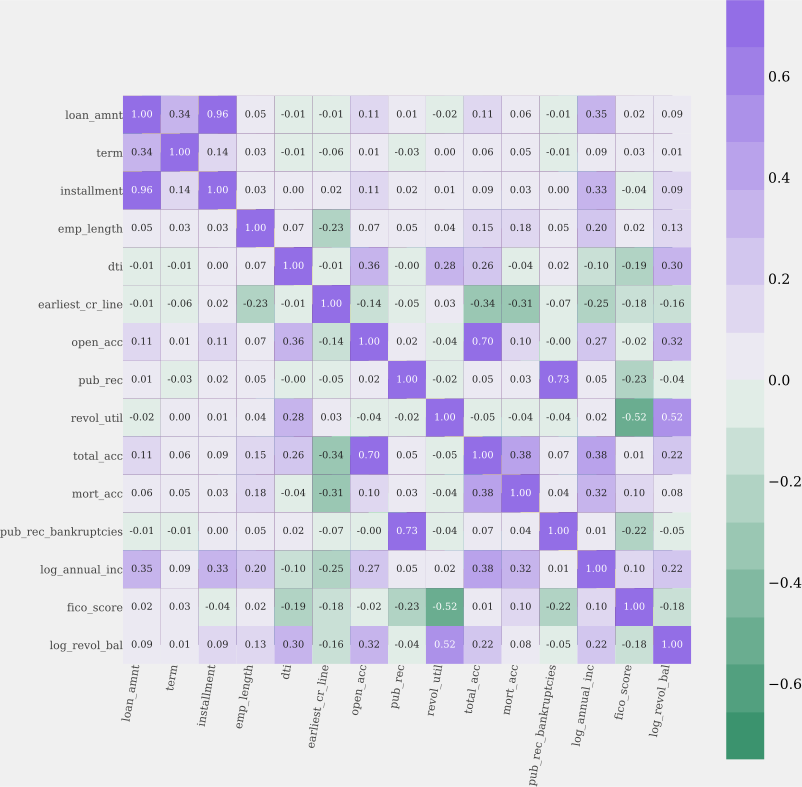

In [119]:
# Plotting the correlation matrix (Pearson)
GREY = '#444443'
plt.figure(figsize=(12,12))

sns.heatmap(X_train[numerical_cols].corr(),vmin=-0.75,vmax=0.75,center=0, cmap=sns.diverging_palette(150, 275, s=80, l=55, n=16),annot=True, fmt='.2f', annot_kws ={'fontsize':'x-small'})
plt.tick_params(labelsize=11, labelcolor=GREY, pad=0)
plt.xticks(rotation=80, horizontalalignment='right', color=GREY)
plt.imshow(X_train[numerical_cols].corr(), vmax=1.0, vmin = 0,  aspect='equal')
PimpViz()

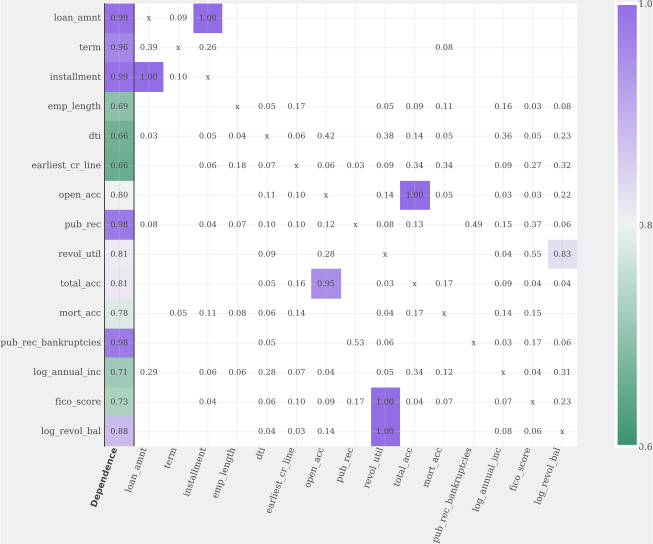

In [115]:
# Plotting the dependence heatmap
# Mean Imputing for the missing values
X_train['emp_length'].fillna(X_train['emp_length'].mean(), inplace=True)
X_train['revol_util'].fillna(X_train['revol_util'].mean(), inplace=True)
X_train['mort_acc'].fillna(X_train['mort_acc'].mean(), inplace=True)
X_train['pub_rec_bankruptcies'].fillna(X_train['pub_rec_bankruptcies'].mean(), inplace=True)

cw = sns.diverging_palette(150, 275, s=80, l=55, n=16, as_cmap=True)
cmap = ListedColormap([cw(x) for x in np.arange(0.1, 0.9, 0.01)])

dep = feature_dependence_matrix(X_train[numerical_cols])
plot_dependence_heatmap(dep, figsize = (14,8), cmap=cw)


In [13]:
from imblearn.under_sampling import RandomUnderSampler
# Building (data preprocessing pipeline) the column transformer 
num_pipeline = Pipeline([
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', StandardScaler())
])
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

col_transform = ColumnTransformer([
    ('cat', categorical_transformer, categorical_cols),
    ('num', num_pipeline, numerical_cols)
])
over = SMOTENC(categorical_features=[X_train.dtypes==object],sampling_strategy=0.3)
under = RandomUnderSampler(random_state=0, sampling_strategy=0.6)
# X_train, y_train = over.fit_resample(X_train, y_train)

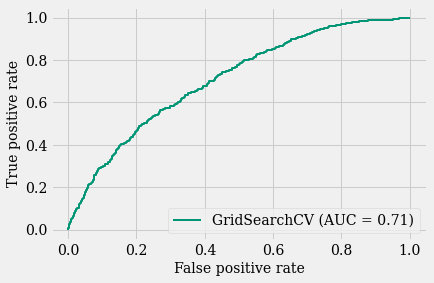

In [8]:
# Logistics regression 
model_pipeline = Pipeline([
    ('preprocessing', col_transform),
    ('over', over),
    ('classifier', LogisticRegression(solver='lbfgs', max_iter=1000)) 
])

param = {
    'classifier__C': [1e-4, 1e-2, 1e-1, 1.001, 3.001, 10, 30, 100, 300, 1000, 3000, 10000]
}
logit = GridSearchCV(estimator=model_pipeline, param_grid=param, cv=10, scoring = 'recall_macro').fit(X_train, y_train)
logit.score(X_test,y_test) #Recall_macro

#Plot ROC curve
with sns.diverging_palette(160, 275, s=100, l=55, n=4):
    logit_auc = plot_roc_curve(logit, X_test, y_test)  
    plt.xlabel('False positive rate', {'fontsize':'medium'})
    plt.ylabel('True positive rate', {'fontsize':'medium'})
    plt.legend(loc='best', fancybox=True, frameon=True)

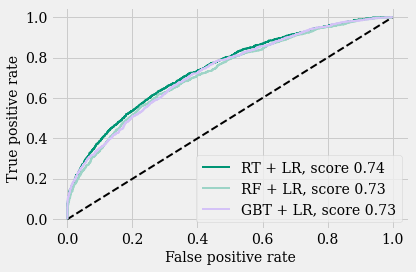

In [17]:
# Using embedding models: 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,stratify=y)

# Preprocessing the data
train_pipeline = Pipeline(steps=[
    ('preprocessing', col_transform),
    ('over', over)])
X_train, y_train = train_pipeline.fit_resample(X_train, y_train)

test_pipeline = Pipeline(steps=[
    ('preprocessing', col_transform)])

X_test, y_test = train_pipeline.fit_resample(X_test, y_test)

X_train, X_train_lr, y_train, y_train_lr = train_test_split(
    X_train, y_train, test_size=0.5,stratify=y_train)

# Unsupervised transformation based on totally random trees
rt = RandomTreesEmbedding(max_depth=3, n_estimators=50,
                          random_state=0)

rt_lm = LogisticRegressionCV(max_iter=10000, cv=5, solver='lbfgs', scoring='roc_auc')
pipeline = make_pipeline(rt, rt_lm)
pipeline.fit(X_train, y_train)
y_pred_rt = pipeline.predict_proba(X_test)[:, 1]
fpr_rt_lm, tpr_rt_lm, _ = roc_curve(y_test, y_pred_rt)

# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=3, n_estimators=50, oob_score=True,max_features='sqrt')
rf_enc = OneHotEncoder()
rf_lm = LogisticRegressionCV(max_iter=10000, cv=5, solver='lbfgs', scoring='roc_auc')
rf.fit(X_train, y_train)
rf_enc.fit(rf.apply(X_train))
rf_lm.fit(rf_enc.transform(rf.apply(X_train_lr)), y_train_lr)
y_pred_rf_lm = rf_lm.predict_proba(rf_enc.transform(rf.apply(X_test)))[:, 1]
fpr_rf_lm, tpr_rf_lm, _ = roc_curve(y_test, y_pred_rf_lm)

# Supervised transformation based on gradient boosted trees
grd = GradientBoostingClassifier(n_estimators=50)
grd_enc = OneHotEncoder()
grd_lm = LogisticRegressionCV(max_iter=1000, cv=5, solver='lbfgs', scoring='roc_auc')
grd.fit(X_train, y_train)
grd_enc.fit(grd.apply(X_train)[:, :, 0])
grd_lm.fit(grd_enc.transform(grd.apply(X_train_lr)[:, :, 0]), y_train_lr)

y_pred_grd_lm = grd_lm.predict_proba(
    grd_enc.transform(grd.apply(X_test)[:, :, 0]))[:, 1]
fpr_grd_lm, tpr_grd_lm, _ = roc_curve(y_test, y_pred_grd_lm)




with sns.diverging_palette(160, 275, s=100, l=55, n=4):
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr_rt_lm, tpr_rt_lm, label='RT + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_rt)))
    plt.plot(fpr_rf_lm, tpr_rf_lm, label='RF + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_rf_lm)))
    plt.plot(fpr_grd_lm, tpr_grd_lm, label='GBT + LR, score {:0.2f}'.format(roc_auc_score(y_test,y_pred_grd_lm)))
    plt.xlabel('False positive rate', {'fontsize':'medium'})
    plt.ylabel('True positive rate', {'fontsize':'medium'})
    plt.legend(loc='best', fancybox=True, frameon=True)
    PimpViz()
